In [1]:
# Load python libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold, learning_curve, validation_curve, GridSearchCV
from skopt import BayesSearchCV
from lightgbm import LGBMRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import lightgbm as lgb
import sys
sys.path.append('/Users/minjielu/anaconda3/envs/python/lib/python3.5/site-packages')

import xgboost as xgb
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew, kurtosis
from matplotlib import pyplot as plt

In [2]:
%%time
# Load data
data = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')

CPU times: user 1min 17s, sys: 9.17 s, total: 1min 26s
Wall time: 1min 34s


In [4]:
# take a look at train and test data
print('train data size: {}*{}'.format(data.shape[0],data.shape[1]))
print('test data size: {}*{}'.format(test.shape[0],test.shape[1]))

train data size: 4459*4993
test data size: 49342*4992


In [5]:
data.sample(10)

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
2249,83a8ff30e,113000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,438666.66,0,0,0,0,0,0,0
4177,ef56acb9e,200000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,1000000.00,0,0,0,0,0,0,0
3291,bed07a1d5,4000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0
460,1ac0da637,2660000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,3000000.00,0,0,0,0,0,0,0
1261,48b984180,340000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0
1403,511bd47ae,7260000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,600000.00,0,0,0,0,0,0,0
4123,ec2ba7aa0,20000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0
4438,fe800ed37,6000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0
2219,815e377be,4000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0
4316,f6e79ba98,6000000.0,0.0,0,0.0,0,0,18560000,0,0,...,0.0,0.0,0.00,4740000,0,0,0,0,0,0


In [6]:
test.sample(10)

,ID,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,20aa07010,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
10804,36e8f2f58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7596,26d48d0ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5474,1c43771a8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42964,def91e652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,800000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40326,d1bba14d7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30245,9c27a4324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,656400.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8085,295964941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,40000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32796,a9c2a8c33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46022,eece30b87,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1857,0973f8675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Count Number of nonzero values of each row
# data['nonzero_cnt'] = (data != 0).sum(axis=1)-2
# sns.distplot(data['nonzero_cnt'],kde=False,rug=True)
# plt.xlim(0,400)

__Some observations are:__
1. Statistic features are more important than features themselves.
2. From learning curves, training scores are decreasing while validation scores are increasing for more training samples.
Therefore, training samples are splitted into smaller samples which have at most 50 non-zero features. In this way, we got more training samples.

In [5]:
'''
train_split = []
new_ID = []
new_target = []
ID_count = 1
for ind, row in data.iterrows():
    row = row[(data.columns != 'nonzero_cnt') & (data.columns != 'ID') & (data.columns != 'target')]
    row = row[row != 0]
    row = row.values
    # If a sample has less than 50 nonzero features, the sample is not splitted and it's padded with zero to 50 features.
    if row.shape[0] < 50:
        new_sample = row
        new_sample = np.pad(new_sample,(50-row.shape[0],0),'constant', constant_values=(0, 0))
        train_split.append(new_sample)
        sample_index = 'sample'+str(ID_count)
        new_ID.append(sample_index) # new_ID stores IDs for new samples.
        new_target.append(data.iloc[ind]['target']) # Target value of the original sample are given to all samples splitted from it.
        ID_count += 1
        continue
    # If a sample has more than 50 but less than 100 nonzero features, the sample is splitted into 2 smaller samples.
    # In this way, samples after split should have at least 25 nonzero features.
    # For samples with more than 100 nonzero features, they are splitted into samples containing 50 nonzero features
    # until less than 100 but more than 50 nonzero features are left.
    num_split = np.floor(row.shape[0]/50)+1
    extra = (row.shape[0] % 50)+50
    i = 0
    while i < num_split-2:
        new_sample = row[i*50:(i+1)*50]
        train_split.append(new_sample)
        sample_index = 'sample'+str(ID_count)
        new_ID.append(sample_index)
        new_target.append(data.iloc[ind]['target'])
        ID_count += 1
        i += 1
    if extra == 50:
        new_sample = row[i*50:(i+1)*50]
        train_split.append(new_sample)
        sample_index = 'sample'+str(ID_count)
        new_ID.append(sample_index)
        new_target.append(data.iloc[ind]['target'])
        ID_count += 1
    else:
        new_sample = row[i*50:int(i*50+np.ceil(extra/2))]
        new_sample = np.pad(new_sample,(int(50-np.ceil(extra/2)),0),'constant', constant_values=(0, 0))
        train_split.append(new_sample)
        sample_index = 'sample'+str(ID_count)
        new_ID.append(sample_index)
        new_target.append(data.iloc[ind]['target'])
        ID_count += 1
        new_sample = row[int(i*50+np.ceil(extra/2)):]
        new_sample = np.pad(new_sample,(50-int(extra-np.ceil(extra/2)),0),'constant', constant_values=(0, 0))
        train_split.append(new_sample)
        sample_index = 'sample'+str(ID_count)
        new_ID.append(sample_index)
        new_target.append(data.iloc[ind]['target'])
        ID_count += 1

# Create new column names for the new train dataframe
new_columns = []
for i in np.arange(50):
    new_columns.append('column'+str(i))
    
train_new = pd.DataFrame(train_split,columns=new_columns)
train_new['ID'] = new_ID
train_new['target'] = new_target
data = train_new
'''

"\ntrain_split = []\nnew_ID = []\nnew_target = []\nID_count = 1\nfor ind, row in data.iterrows():\n    row = row[(data.columns != 'nonzero_cnt') & (data.columns != 'ID') & (data.columns != 'target')]\n    row = row[row != 0]\n    row = row.values\n    if row.shape[0] < 50:\n        new_sample = row\n        new_sample = np.pad(new_sample,(50-row.shape[0],0),'constant', constant_values=(0, 0))\n        train_split.append(new_sample)\n        sample_index = 'sample'+str(ID_count)\n        new_ID.append(sample_index)\n        new_target.append(data.iloc[ind]['target'])\n        ID_count += 1\n        continue\n    num_split = np.floor(row.shape[0]/50)+1\n    extra = (row.shape[0] % 50)+50\n    i = 0\n    while i < num_split-2:\n        new_sample = row[i*50:(i+1)*50]\n        train_split.append(new_sample)\n        sample_index = 'sample'+str(ID_count)\n        new_ID.append(sample_index)\n        new_target.append(data.iloc[ind]['target'])\n        ID_count += 1\n        i += 1\n    if e

## 1. Feature engineering

In [3]:
# Take out magic features discovered by olivier
magic_features = ['f190486d6', 'c47340d97', 'eeb9cd3aa', '66ace2992', 'e176a204a',
        '491b9ee45', '1db387535', 'c5a231d81', '0572565c2', '024c577b9',
        '15ace8c9f', '23310aa6f', '9fd594eec', '58e2e02e6', '91f701ba2',
        'adb64ff71', '2ec5b290f', '703885424', '26fc93eb7', '6619d81fc',
        '0ff32eb98', '70feb1494', '58e056e12', '1931ccfdd', '1702b5bf0',
        '58232a6fb', '963a49cdc', 'fc99f9426', '241f0f867', '5c6487af1',
        '62e59a501', 'f74e8f13d', 'fb49e4212', '190db8488', '324921c7b',
        'b43a7cfd5', '9306da53f', 'd6bb78916', 'fb0f5dbfe', '6eef030c1']

features = [f for f in data.columns if f not in ['target', 'ID']]
magic_features_loc = [features.index(x) for x in magic_features]

In [4]:
%%time
# Statistic features and magic features are used as inputs for machine learning algortihms
features = [f for f in data.columns if f not in ['target', 'ID']]

def to_hist_func(row):
    count = row[row != 0].shape[0]
    hist = []
    hist.extend(row[magic_features_loc]) # Add Santander 46 magic features.
    # Replace 0 values with null, this procedure seems to improve the performance of regressions.
    # hist[hist == 0] = np.nan
    # When statistic features are calculated, zero values are removed.
    row = row[row != 0]
    hist.append(np.min(row)) # Add the minimum
    # hist.append(np.percentile(row,10)) # Add percentiles
    # hist.append(np.percentile(row,20))
    hist.append(np.percentile(row,25))
    # hist.append(np.percentile(row,30))
    # hist.append(np.percentile(row,40))
    hist.append(np.percentile(row,50))
    # hist.append(np.percentile(row,60))
    # hist.append(np.percentile(row,70))
    hist.append(np.percentile(row,75))
    # hist.append(np.percentile(row,80))
    # hist.append(np.percentile(row,90))
    hist.append(np.max(row)) # Add the maximum
    # hist.append(np.mean(row)) # Add the mean
    # hist.append(np.median(row)) # Add the median
    # hist.append(np.sum(row)) # Add sum
    # Add fine histogram.
    # for x in np.arange(8,17,0.2):
        # hist.append(row[(row < x+1) & (row >= x)].shape[0])
    # Add coarse histogram.
    # for x in np.arange(8,17,1):
        # hist.append(row[(row < x+2) & (row >= x)].shape[0])
    # hist.append(row[(row < 23) & (row >= 20)].shape[0])
    hist.append(count)  # Add the number of nonzero features
    hist.append(skew(row)) # Add the skewness
    hist.append(kurtosis(row)) # Add the kurtosis
    '''
    # One observation is that there are lots of repeated values
    # Therefore, statistic features are also extracted after these repeated values are removed
    row_unique = np.unique(row)
    hist.append(np.min(row_unique))
    hist.append(np.percentile(row_unique,10))
    hist.append(np.percentile(row_unique,20))
    hist.append(np.percentile(row_unique,25))
    hist.append(np.percentile(row_unique,30))
    hist.append(np.percentile(row_unique,40))
    hist.append(np.percentile(row_unique,50))
    hist.append(np.percentile(row_unique,60))
    hist.append(np.percentile(row_unique,70))
    hist.append(np.percentile(row_unique,75))
    hist.append(np.percentile(row_unique,80))
    hist.append(np.percentile(row_unique,90))
    hist.append(np.max(row_unique))
    for x in np.arange(8,17,0.2):
        hist.append(row_unique[(row_unique < x+1) & (row_unique >= x)].shape[0])
    for x in np.arange(8,17,1):
        hist.append(row_unique[(row_unique < x+2) & (row_unique >= x)].shape[0])
    hist.append(row_unique[(row_unique < 23) & (row_unique >= 20)].shape[0])
    hist.append(len(row_unique)) # Add the number of unique values.
    hist.append(skew(row_unique))
    hist.append(kurtosis(row_unique))
    '''
    pdrow = pd.Series(row)
    # Add the three most frequent values. If there is not enough unique values, zeroes or nans are used instead
    unique_values = pdrow.value_counts()
    hist.append(unique_values.index[0])
    if unique_values.shape[0] == 1:
        hist.extend([0,0]) 
        # hist.extend([np.nan,np.nan])
        return hist
    hist.append(unique_values.index[1])
    if unique_values.shape[0] == 2:
        hist.extend([0])
        # hist.extend([np.nan])
        return hist
    hist.append(unique_values.index[2])
    return hist


# Generate statistic features for train data
hist_data = np.apply_along_axis(
    func1d=to_hist_func, 
    axis=1, 
    arr=(np.log1p(data[features])).astype(float)) 

CPU times: user 7.76 s, sys: 466 ms, total: 8.22 s
Wall time: 8.56 s


In [5]:
%%time
# Generate statistic features for test data
hist_test = np.apply_along_axis(
    func1d=to_hist_func, 
    axis=1, 
    arr=(np.log1p(test[features])).astype(float))

CPU times: user 1min 43s, sys: 6.57 s, total: 1min 50s
Wall time: 2min


## 2. Hyperparameter tuning for machine learning algorithms

### a. Using GridSearchCV

In [6]:
# Define a score function that returns mean squared log error, since the built-in mean_squared_log_error of sklearn somehow doesn't work
def my_own_score(ground_truth,predictions):
    return (mean_squared_error(ground_truth,predictions) ** .5)
    
score = make_scorer(my_own_score,greater_is_better=False)

In [7]:
# Hyperparameter tuning for Extra Trees regressor
ExTree_params = {'n_estimators':[1000,1500,2000],
                'max_features':[.3,.6,.8],
                'max_depth':[5,10,15],
                'min_samples_leaf':[5,10,15,20],
                }

gsExTree = GridSearchCV(ExtraTreesRegressor(random_state=3,n_jobs=-1),param_grid = ExTree_params,scoring=score,cv=5,n_jobs=4,verbose=1)
gsExTree.fit(hist_data,np.log1p(data['target']))
print(gsExTree.best_params_)
print(gsExTree.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 10.8min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 47.0min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed: 69.2min finished


{'max_depth': 15, 'max_features': 0.8, 'min_samples_leaf': 5, 'n_estimators': 2000}
-1.3476046142775846


In [8]:
# Hyperparameter tuning for K Nearest Neigbhors regressor
KNN_params = {'n_neighbors':[5,10,15,20],
              'weights':['uniform','distance'],
              'algorithm':['ball_tree','kd_tree'],
              }

gsKNN = GridSearchCV(KNeighborsRegressor(n_jobs=-1),param_grid = KNN_params,scoring=score,cv=5,n_jobs=4,verbose=1)
gsKNN.fit(hist_data,np.log1p(data['target']))
print(gsKNN.best_params_)
print(gsKNN.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   22.7s


{'algorithm': 'ball_tree', 'n_neighbors': 20, 'weights': 'distance'}
-1.6768700799098006


[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:   37.3s finished


In [ ]:
'''
# Hyperparameter tuning for Support Vector regressor
SVR_params = {'n_neighbors':[1000,1500,2000],
                'weights':[.3,.6,.8],
                'algorithm':[5,10,15],
                }

gsSVR = GridSearchCV(SVR(n_jobs=-1),param_grid = SVR_params,scoring=score,cv=5,n_jobs=4,verbose=1)
gsSVR.fit(hist_data,np.log1p(data['target']))
gsSVR.best_params_
'''

In [9]:
# Hyperparameter tuning for Decision Tree regressor
DT_params = {'criterion':['mse','friedman_mse','mae'],
            'splitter':['best','random'],
            'min_samples_leaf':[5,10,15,20],
            }

gsDT = GridSearchCV(DecisionTreeRegressor(),param_grid = DT_params,scoring=score,cv=5,n_jobs=4,verbose=1)
gsDT.fit(hist_data,np.log1p(data['target']))
print(gsDT.best_params_)
print(gsDT.best_score_)


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.9s


{'criterion': 'friedman_mse', 'min_samples_leaf': 20, 'splitter': 'random'}
-1.4691343903360743


[Parallel(n_jobs=4)]: Done 120 out of 120 | elapsed:  1.3min finished


In [10]:
# Hyperparameter tuning for Random Forest regressor
RF_params = {'n_estimators':[1000,1500,2000],
            'max_features':[.3,.6,.8],
            'max_depth':[5,10,15],
            'min_samples_leaf':[5,10,15,20],
            }

gsRF = GridSearchCV(RandomForestRegressor(random_state=3,n_jobs=-1),param_grid = RF_params,scoring=score,cv=5,n_jobs=4,verbose=1)
gsRF.fit(hist_data,np.log1p(data['target']))
print(gsRF.best_params_)
print(gsRF.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed: 22.2min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed: 60.1min
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed: 80.6min finished


{'max_depth': 15, 'max_features': 0.3, 'min_samples_leaf': 5, 'n_estimators': 1500}
-1.3425086370568988


In [11]:
# Hyperparameter tuning for AdaBoost regressor
ADBoost_params = {'n_estimators':[100,300,500],
                    'learning_rate':[.05,.1,.3,.5],
                    'loss':['linear','square','exponential'],
                    }

gsADBoost = GridSearchCV(AdaBoostRegressor(random_state=3),param_grid = ADBoost_params,scoring=score,cv=5,n_jobs=4,verbose=1)
gsADBoost.fit(hist_data,np.log1p(data['target']))
print(gsADBoost.best_params_)
print(gsADBoost.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:  3.9min finished


{'learning_rate': 0.05, 'loss': 'exponential', 'n_estimators': 100}
-1.4110024994056196


In [12]:
# Hyperparameter tuning for LightGBM regressor
lgb_params = {
    'num_leaves': [30,58,70],
    'subsample': [0.4,0.6143,0.85],
    'colsample_bytree': [0.4,0.6453,0.85],
    'max_depth': [5,10,15],
    'learning_rate': [0.05,.1,.3,.5],
}

mylgb = lgb.LGBMRegressor(objective='regression', random_state=3, boosting_type='gbdt', seed=3, min_child_weight=np.power(10, -0.1477), reg_lambda=np.power(10, 1.7570), reg_alpha=np.power(10, -2.2887), min_split_gain=np.power(10, -2.5988))

gsLGBoost = GridSearchCV(mylgb,param_grid = lgb_params,scoring=score,cv=5,n_jobs=4,verbose=1)
gsLGBoost.fit(hist_data,np.log1p(data['target']))
print(gsLGBoost.best_params_)
print(gsLGBoost.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  7.9min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed: 13.0min
[Parallel(n_jobs=4)]: Done 1620 out of 1620 | elapsed: 17.6min finished


{'colsample_bytree': 0.4, 'learning_rate': 0.05, 'max_depth': 15, 'num_leaves': 70, 'subsample': 0.4}
-1.3531434457501161


### b. Using BayesSearchCV

In [13]:

def status_print(optim_result):
    """Status callback during bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bsLGBoost.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bsLGBoost.best_params_)
    print('Model #{}\nBest MSE: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bsLGBoost.best_score_, 4),
        bsLGBoost.best_params_
    ))
    
    # Save all model results
    clf_name = bsLGBoost.estimator.__class__.__name__
    # all_models.to_csv(clf_name+"_cv_results.csv")

# hyperparameter tuning for LightGBM regressor using Bayesian optimization
search_params = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'num_leaves': (10, 100),      
    'max_depth': (0, 50),
    'min_child_samples': (0, 50),
    'max_bin': (100, 1000),
    'subsample_freq': (0, 10),
    'min_child_weight': (0, 10),
    'reg_lambda': (1e-9, 1000, 'log-uniform'),
    'reg_alpha': (1e-9, 1.0, 'log-uniform'),
    'n_estimators': (50, 150),
    'min_split_gain': (0.001, 10.0, 'log-uniform')
}

mylgb = lgb.LGBMRegressor(objective='regression', random_state=3)

bsLGBoost = BayesSearchCV(mylgb, search_spaces=search_params,scoring=score, cv=KFold(n_splits=5,shuffle=True,random_state=1), n_jobs=1, n_iter=100, verbose=0, refit=True, random_state=3)

bsLGBoost.fit(hist_data,np.log1p(data['target']),callback=status_print)

Model #1
Best MSE: -1.4698
Best params: {'learning_rate': 0.41632686502344207, 'max_bin': 285, 'max_depth': 49, 'min_child_samples': 16, 'min_child_weight': 1, 'min_split_gain': 0.0035709054039510754, 'n_estimators': 72, 'num_leaves': 85, 'reg_alpha': 3.040308671030701e-07, 'reg_lambda': 180.50090239517365, 'subsample_freq': 1}

Model #2
Best MSE: -1.4698
Best params: {'learning_rate': 0.41632686502344207, 'max_bin': 285, 'max_depth': 49, 'min_child_samples': 16, 'min_child_weight': 1, 'min_split_gain': 0.0035709054039510754, 'n_estimators': 72, 'num_leaves': 85, 'reg_alpha': 3.040308671030701e-07, 'reg_lambda': 180.50090239517365, 'subsample_freq': 1}

Model #3
Best MSE: -1.4698
Best params: {'learning_rate': 0.41632686502344207, 'max_bin': 285, 'max_depth': 49, 'min_child_samples': 16, 'min_child_weight': 1, 'min_split_gain': 0.0035709054039510754, 'n_estimators': 72, 'num_leaves': 85, 'reg_alpha': 3.040308671030701e-07, 'reg_lambda': 180.50090239517365, 'subsample_freq': 1}

Model #

Model #26
Best MSE: -1.4201
Best params: {'learning_rate': 0.0449301571971858, 'max_bin': 336, 'max_depth': 3, 'min_child_samples': 6, 'min_child_weight': 7, 'min_split_gain': 0.8915210870075039, 'n_estimators': 132, 'num_leaves': 96, 'reg_alpha': 0.0015801325042661212, 'reg_lambda': 0.00021598607657678489, 'subsample_freq': 8}

Model #27
Best MSE: -1.4201
Best params: {'learning_rate': 0.0449301571971858, 'max_bin': 336, 'max_depth': 3, 'min_child_samples': 6, 'min_child_weight': 7, 'min_split_gain': 0.8915210870075039, 'n_estimators': 132, 'num_leaves': 96, 'reg_alpha': 0.0015801325042661212, 'reg_lambda': 0.00021598607657678489, 'subsample_freq': 8}

Model #28
Best MSE: -1.4201
Best params: {'learning_rate': 0.0449301571971858, 'max_bin': 336, 'max_depth': 3, 'min_child_samples': 6, 'min_child_weight': 7, 'min_split_gain': 0.8915210870075039, 'n_estimators': 132, 'num_leaves': 96, 'reg_alpha': 0.0015801325042661212, 'reg_lambda': 0.00021598607657678489, 'subsample_freq': 8}

Model #

Model #51
Best MSE: -1.4201
Best params: {'learning_rate': 0.0449301571971858, 'max_bin': 336, 'max_depth': 3, 'min_child_samples': 6, 'min_child_weight': 7, 'min_split_gain': 0.8915210870075039, 'n_estimators': 132, 'num_leaves': 96, 'reg_alpha': 0.0015801325042661212, 'reg_lambda': 0.00021598607657678489, 'subsample_freq': 8}

Model #52
Best MSE: -1.4201
Best params: {'learning_rate': 0.0449301571971858, 'max_bin': 336, 'max_depth': 3, 'min_child_samples': 6, 'min_child_weight': 7, 'min_split_gain': 0.8915210870075039, 'n_estimators': 132, 'num_leaves': 96, 'reg_alpha': 0.0015801325042661212, 'reg_lambda': 0.00021598607657678489, 'subsample_freq': 8}

Model #53
Best MSE: -1.4201
Best params: {'learning_rate': 0.0449301571971858, 'max_bin': 336, 'max_depth': 3, 'min_child_samples': 6, 'min_child_weight': 7, 'min_split_gain': 0.8915210870075039, 'n_estimators': 132, 'num_leaves': 96, 'reg_alpha': 0.0015801325042661212, 'reg_lambda': 0.00021598607657678489, 'subsample_freq': 8}

Model #

Model #76
Best MSE: -1.4201
Best params: {'learning_rate': 0.0449301571971858, 'max_bin': 336, 'max_depth': 3, 'min_child_samples': 6, 'min_child_weight': 7, 'min_split_gain': 0.8915210870075039, 'n_estimators': 132, 'num_leaves': 96, 'reg_alpha': 0.0015801325042661212, 'reg_lambda': 0.00021598607657678489, 'subsample_freq': 8}

Model #77
Best MSE: -1.4201
Best params: {'learning_rate': 0.0449301571971858, 'max_bin': 336, 'max_depth': 3, 'min_child_samples': 6, 'min_child_weight': 7, 'min_split_gain': 0.8915210870075039, 'n_estimators': 132, 'num_leaves': 96, 'reg_alpha': 0.0015801325042661212, 'reg_lambda': 0.00021598607657678489, 'subsample_freq': 8}

Model #78
Best MSE: -1.4201
Best params: {'learning_rate': 0.0449301571971858, 'max_bin': 336, 'max_depth': 3, 'min_child_samples': 6, 'min_child_weight': 7, 'min_split_gain': 0.8915210870075039, 'n_estimators': 132, 'num_leaves': 96, 'reg_alpha': 0.0015801325042661212, 'reg_lambda': 0.00021598607657678489, 'subsample_freq': 8}

Model #

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       learning_rate=0.1, max_depth=-1, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
       n_jobs=-1, num_leaves=31, objective='regression', random_state=3,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_iter=100, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=3,
       refit=True, return_train_score=False,
       scoring=make_scorer(my_own_score, greater_is_better=False),
       search_spaces={'learning_rate': (0.01, 1.0, 'log-uniform'), 'num_leaves': (10, 100), 'max_depth': (0, 50), 'min_child_samples': (0, 50), 'max_bin': (100, 1000), 'subsample_freq': (0, 10), 'min_child_weight': (0, 10), 'reg_lambda': (

In [24]:
def status_print(optim_result):
    """Status callback durring bayesian hyperparameter search"""
    
    # Get all the models tested so far in DataFrame format
    all_models = pd.DataFrame(bsXGBoost.cv_results_)    
    
    # Get current parameters and the best parameters    
    best_params = pd.Series(bsXGBoost.best_params_)
    print('Model #{}\nBest MSE: {}\nBest params: {}\n'.format(
        len(all_models),
        np.round(bsXGBoost.best_score_, 4),
        bsXGBoost.best_params_
    ))
    
    # Save all model results
    # clf_name = bsXGBoost.estimator.__class__.__name__
    # all_models.to_csv(clf_name+"_cv_results.csv")

# Hyperparameter tuning for XGBM regressor using Bayesian optimization
search_params = {
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'n_estimators': (50, 150),      
    'max_depth': (0, 50),
    'min_child_weight': (0, 100),
    'subsample': (0.1, 1),
    'colsample_bytree': (0.1, 1),
    'colsample_bylevel': (0.1, 1),
    'reg_lambda': (1e-9, 1000, 'log-uniform'),
    'gamma': (0.001, 10.0, 'log-uniform'),
}

myxgb = xgb.XGBRegressor(objective='reg:linear', booster='gbtree', eval_metric='rmse', seed=3)

bsXGBoost = BayesSearchCV(myxgb, search_spaces=search_params,scoring=score, cv=KFold(n_splits=5,shuffle=True,random_state=1), n_jobs=1, n_iter=100, verbose=0, refit=True, random_state=3)

bsXGBoost.fit(hist_data,np.log1p(data['target']),callback=status_print)

Model #1
Best MSE: -1.5754
Best params: {'colsample_bylevel': 0.8287454963084796, 'colsample_bytree': 0.2849290713064093, 'gamma': 8.039890727039243, 'learning_rate': 0.041835896677972224, 'max_depth': 5, 'min_child_weight': 14, 'n_estimators': 72, 'reg_lambda': 11.136221905549482, 'subsample': 0.3482917678121952}

Model #2
Best MSE: -1.3966
Best params: {'colsample_bylevel': 0.9934642820569056, 'colsample_bytree': 0.2530668595918294, 'gamma': 0.012316868595379424, 'learning_rate': 0.1797666509195365, 'max_depth': 5, 'min_child_weight': 79, 'n_estimators': 148, 'reg_lambda': 0.004306594432065667, 'subsample': 0.8028532295629552}

Model #3
Best MSE: -1.3966
Best params: {'colsample_bylevel': 0.9934642820569056, 'colsample_bytree': 0.2530668595918294, 'gamma': 0.012316868595379424, 'learning_rate': 0.1797666509195365, 'max_depth': 5, 'min_child_weight': 79, 'n_estimators': 148, 'reg_lambda': 0.004306594432065667, 'subsample': 0.8028532295629552}

Model #4
Best MSE: -1.3898
Best params: {

Model #27
Best MSE: -1.3866
Best params: {'colsample_bylevel': 0.11739821927857827, 'colsample_bytree': 0.5237448013094596, 'gamma': 0.008851074161704388, 'learning_rate': 0.14726209429563958, 'max_depth': 6, 'min_child_weight': 76, 'n_estimators': 86, 'reg_lambda': 37.55701902361182, 'subsample': 0.9478410020011561}

Model #28
Best MSE: -1.3866
Best params: {'colsample_bylevel': 0.11739821927857827, 'colsample_bytree': 0.5237448013094596, 'gamma': 0.008851074161704388, 'learning_rate': 0.14726209429563958, 'max_depth': 6, 'min_child_weight': 76, 'n_estimators': 86, 'reg_lambda': 37.55701902361182, 'subsample': 0.9478410020011561}

Model #29
Best MSE: -1.3866
Best params: {'colsample_bylevel': 0.11739821927857827, 'colsample_bytree': 0.5237448013094596, 'gamma': 0.008851074161704388, 'learning_rate': 0.14726209429563958, 'max_depth': 6, 'min_child_weight': 76, 'n_estimators': 86, 'reg_lambda': 37.55701902361182, 'subsample': 0.9478410020011561}

Model #30
Best MSE: -1.3866
Best params:

Model #53
Best MSE: -1.3815
Best params: {'colsample_bylevel': 0.15567243866324224, 'colsample_bytree': 0.8757947456612318, 'gamma': 0.6650550803691171, 'learning_rate': 0.04713262903659931, 'max_depth': 50, 'min_child_weight': 93, 'n_estimators': 118, 'reg_lambda': 1e-09, 'subsample': 0.8779734658590591}

Model #54
Best MSE: -1.3815
Best params: {'colsample_bylevel': 0.15567243866324224, 'colsample_bytree': 0.8757947456612318, 'gamma': 0.6650550803691171, 'learning_rate': 0.04713262903659931, 'max_depth': 50, 'min_child_weight': 93, 'n_estimators': 118, 'reg_lambda': 1e-09, 'subsample': 0.8779734658590591}

Model #55
Best MSE: -1.3815
Best params: {'colsample_bylevel': 0.15567243866324224, 'colsample_bytree': 0.8757947456612318, 'gamma': 0.6650550803691171, 'learning_rate': 0.04713262903659931, 'max_depth': 50, 'min_child_weight': 93, 'n_estimators': 118, 'reg_lambda': 1e-09, 'subsample': 0.8779734658590591}

Model #56
Best MSE: -1.3815
Best params: {'colsample_bylevel': 0.15567243866

Model #81
Best MSE: -1.3786
Best params: {'colsample_bylevel': 0.4769829845526664, 'colsample_bytree': 0.1, 'gamma': 0.11943739752515738, 'learning_rate': 0.0601780856322375, 'max_depth': 9, 'min_child_weight': 100, 'n_estimators': 150, 'reg_lambda': 1e-09, 'subsample': 1.0}

Model #82
Best MSE: -1.3786
Best params: {'colsample_bylevel': 0.4769829845526664, 'colsample_bytree': 0.1, 'gamma': 0.11943739752515738, 'learning_rate': 0.0601780856322375, 'max_depth': 9, 'min_child_weight': 100, 'n_estimators': 150, 'reg_lambda': 1e-09, 'subsample': 1.0}

Model #83
Best MSE: -1.3786
Best params: {'colsample_bylevel': 0.4769829845526664, 'colsample_bytree': 0.1, 'gamma': 0.11943739752515738, 'learning_rate': 0.0601780856322375, 'max_depth': 9, 'min_child_weight': 100, 'n_estimators': 150, 'reg_lambda': 1e-09, 'subsample': 1.0}

Model #84
Best MSE: -1.3786
Best params: {'colsample_bylevel': 0.4769829845526664, 'colsample_bytree': 0.1, 'gamma': 0.11943739752515738, 'learning_rate': 0.060178085632

BayesSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='rmse', gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=3, silent=True, subsample=1),
       fit_params=None, iid=True, n_iter=100, n_jobs=1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=3,
       refit=True, return_train_score=False,
       scoring=make_scorer(my_own_score, greater_is_better=False),
       search_spaces={'learning_rate': (0.01, 1.0, 'log-uniform'), 'n_estimators': (50, 150), 'max_depth': (0, 50), 'min_child_weight': (0, 100), 'subsample': (0.1, 1), 'colsample_bytree': (0.1, 1), 'colsample_bylevel': (0.1, 1), 'reg_lam

## 3. Plot learning curves

In [23]:
def plot_learning_curve(regressor, title, x, y, score):
    train_sizes, train_scores, test_scores = learning_curve(regressor, x, y, scoring=score, train_sizes = np.linspace(0.1,1.0,7), cv = 5)
    plt.figure()
    plt.title(title)
    plt.xlabel('Number of samples')
    plt.ylabel('score')
    plt.grid()
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/Users/minjielu/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

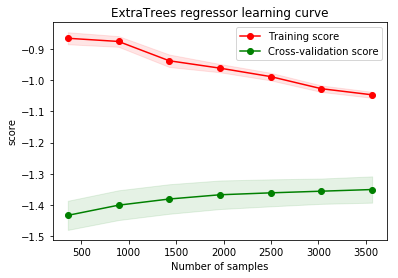

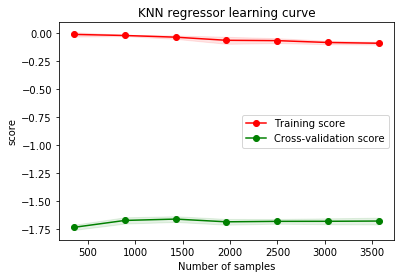

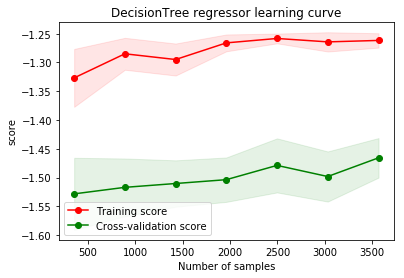

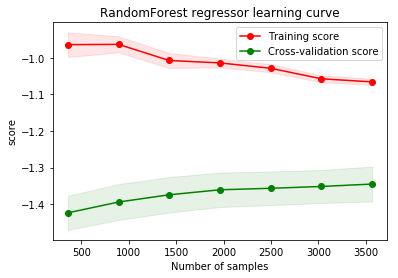

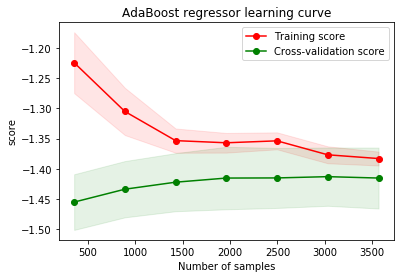

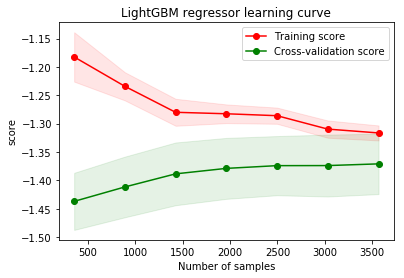

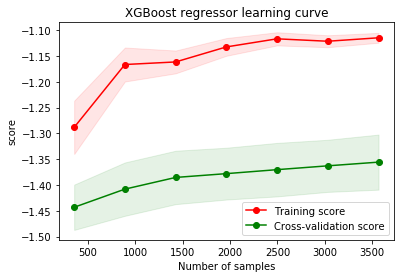

In [24]:
# Define regressors using the best parameters found by grid search or Bayesian search
myET = ExtraTreesRegressor(n_estimators=1000, max_features=.8, max_depth=10, min_samples_leaf=5, random_state=3, n_jobs=-1)
myKNN = KNeighborsRegressor(n_neighbors=20, weights='distance', algorithm='kd_tree', n_jobs=-1)
myDT = DecisionTreeRegressor(criterion='friedman_mse', splitter='random', min_samples_leaf=15)
myRF = RandomForestRegressor(n_estimators=2000, max_features=.3, max_depth=10, min_samples_leaf=5,random_state=3,n_jobs=-1)
myADBoost = AdaBoostRegressor(n_estimators=100, learning_rate=0.05, loss='linear', random_state=3)
# mylgb = lgb.LGBMRegressor(num_leaves=58,subsample=.4,colsample_bytree=.4,max_depth=10,learning_rate=0.05,objective='regression',random_state=3,boosting_type='gbdt',seed=3,min_child_weight=np.power(10,-0.1477),reg_lambda=np.power(10,1.7570),reg_alpha=np.power(10,-2.2887),min_split_gain=np.power(10,-2.5988))
# For data with leak items added
# mylgb = lgb.LGBMRegressor(objective='regression', random_state=3, learning_rate=0.0353, max_bin=386, max_depth=19, min_child_samples=19,min_child_weight=4, min_split_gain=0.464, n_estimators=124, num_leaves=51, reg_alpha=0.000246, reg_lambda=0.0001696, subsample_freq=4)
# myxgb = xgb.XGBRegressor(objective='reg:linear',booster='gbtree',seed=3,colsample_bylevel=0.477,colsample_bytree=0.1,gamma=0.119,learning_rate=0.0602,max_depth=9,min_child_weight=100,n_estimators=150,reg_lambda=1e-9,subsample=1.0)
# For data with train leak removed
# mylgb = lgb.LGBMRegressor(objective='regression', random_state=3, learning_rate=0.0237, max_bin=100, max_depth=50, min_child_samples=7,min_child_weight=2, min_split_gain=0.001, n_estimators=150, num_leaves=10, reg_alpha=1e-9, reg_lambda=3.12e-8, subsample_freq=0)
# myxgb = xgb.XGBRegressor(objective='reg:linear',booster='gbtree',seed=3,colsample_bylevel=0.117,colsample_bytree=0.524,gamma=0.00885,learning_rate=0.147,max_depth=6,min_child_weight=76,n_estimators=86,reg_lambda=37.56,subsample=0.948)
mylgb = lgb.LGBMRegressor(num_leaves=60,subsample=.4,colsample_bytree=.6,max_depth=2,learning_rate=0.1,objective='regression',random_state=3,boosting_type='gbdt',seed=3,min_child_weight=np.power(10,-0.1477),reg_lambda=np.power(10,1.7570),reg_alpha=np.power(10,-2.2887),min_split_gain=np.power(10,-2.5988))
myxgb = xgb.XGBRegressor(objective='reg:linear',booster='gbtree',seed=3,colsample_bylevel=0.44,colsample_bytree=0.53,gamma=1.98e-3,learning_rate=0.0355,max_depth=44,min_child_weight=79,n_estimators=144,reg_lambda=0.0355,subsample=1.0)

# Plot learning curves for all regressors
plot_learning_curve(myET,'ExtraTrees regressor learning curve',hist_data,np.log1p(data['target']),score)
plot_learning_curve(myKNN,'KNN regressor learning curve',hist_data,np.log1p(data['target']),score)
plot_learning_curve(myDT,'DecisionTree regressor learning curve',hist_data,np.log1p(data['target']),score)
plot_learning_curve(myRF,'RandomForest regressor learning curve',hist_data,np.log1p(data['target']),score)
plot_learning_curve(myADBoost,'AdaBoost regressor learning curve',hist_data,np.log1p(data['target']),score)
plot_learning_curve(mylgb,'LightGBM regressor learning curve',hist_data,np.log1p(data['target']),score)
plot_learning_curve(myxgb,'XGBoost regressor learning curve',hist_data,np.log1p(data['target']),score)

## 4. Stacking

In [8]:
# Generate meta features using selected regressors
def generate_meta_features(regressor,x,y,z):
    folds = KFold(n_splits=5,shuffle=True,random_state=1)
    oof_preds = np.zeros(x.shape[0])
    test_preds = np.zeros(z.shape[0])
    
    for n_fold, (trn_, val_) in enumerate(folds.split(x)):
        regressor.fit(x[trn_],y[trn_])
        oof_preds[val_] = regressor.predict(hist_data[val_])
        test_preds += regressor.predict(z) / folds.n_splits
        
    return oof_preds,test_preds

In [9]:
ET_meta,ET_test_meta = generate_meta_features(myET,hist_data,np.log1p(data['target']),hist_test)
KNN_meta,KNN_test_meta = generate_meta_features(myKNN,hist_data,np.log1p(data['target']),hist_test)
DT_meta,DT_test_meta = generate_meta_features(myDT,hist_data,np.log1p(data['target']),hist_test)
RF_meta,RF_test_meta = generate_meta_features(myRF,hist_data,np.log1p(data['target']),hist_test)
ADBoost_meta,ADBoost_test_meta = generate_meta_features(myADBoost,hist_data,np.log1p(data['target']),hist_test)
LGB_meta,LGB_test_meta = generate_meta_features(mylgb,hist_data,np.log1p(data['target']),hist_test)
XGB_meta,XGB_test_meta = generate_meta_features(myxgb,hist_data,np.log1p(data['target']),hist_test)
ET_meta = pd.Series(ET_meta,name='ET_meta')
KNN_meta = pd.Series(KNN_meta,name='KNN_meta')
DT_meta = pd.Series(DT_meta,name='DT_meta')
RF_meta = pd.Series(RF_meta,name='RF_meta')
ADBoost_meta = pd.Series(ADBoost_meta,name='ADBoost_meta')
LGB_meta = pd.Series(LGB_meta,name='LGB_meta')
XGB_meta = pd.Series(XGB_meta,name='XGB_meta')
ET_test_meta = pd.Series(ET_test_meta,name='ET_meta')
KNN_test_meta = pd.Series(KNN_test_meta,name='KNN_meta')
DT_test_meta = pd.Series(DT_test_meta,name='DT_meta')
RF_test_meta = pd.Series(RF_test_meta,name='RF_meta')
ADBoost_test_meta = pd.Series(ADBoost_test_meta,name='ADBoost_meta')
LGB_test_meta = pd.Series(LGB_test_meta,name='LGB_meta')
XGB_test_meta = pd.Series(XGB_test_meta,name='XGB_meta')

train_meta=pd.concat([ET_meta,KNN_meta,DT_meta,RF_meta,ADBoost_meta,LGB_meta,XGB_meta],axis=1) # Meta features for train data
test_meta=pd.concat([ET_test_meta,KNN_test_meta,DT_test_meta,RF_test_meta,ADBoost_test_meta,LGB_test_meta,XGB_test_meta],axis=1) # Meta features for test data


Cross validation score for ET_meta: 1.3461180696443158
Cross validation score for KNN_meta: 1.6717586558611868
Cross validation score for DT_meta: 1.464237959547263
Cross validation score for RF_meta: 1.3439324357231357
Cross validation score for ADBoost_meta: 1.4146786499528998
Cross validation score for LGB_meta: 1.3685529619057677
Cross validation score for XGB_meta: 1.3578524500200722


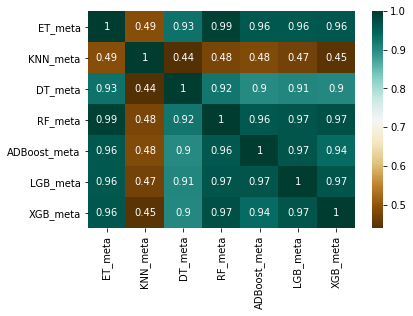

In [10]:
for column in train_meta.columns:
    print('Cross validation score for ' + column + ': {}'.format(mean_squared_error(np.log1p(data['target']),train_meta[column]) ** .5))
g = sns.heatmap(test_meta[["ET_meta","KNN_meta","DT_meta","RF_meta","ADBoost_meta",'LGB_meta','XGB_meta']].corr(),cmap="BrBG",annot=True)

Ensembling models sometimes provides better result than using them individually. In my case, ExtraTrees, RandomForest, LightGBM, and XGBoost have very good cross validation scores on train set. ExtraTrees and RandomForest actually overfits on train set so they provide worse scores on test set. Ensembling LightGBM and XGBoost gives me the best public leaderboard score 1.38.

In [19]:
'''
for i in np.arange(0,1,0.05):
    oof_preds = LGB_meta*i+XGB_meta*(1-i)
    print(str(i)+':'+str(mean_squared_error(oof_preds,np.log1p(data['target'])) ** .5)
'''
    
# sub_preds = (RF_test_meta+LGB_test_meta)/2
# sub_preds = (ET_test_meta+LGB_test_meta)/2
# Generate the final result using the average prediction from LightGBM and XGBoost regressor
sub_preds = (LGB_test_meta+XGB_test_meta)/2

1.3594429380401734
1.3589433808552502
1.3585873476770474
1.3583749513594796
1.358306259283391
1.3583812932497512
1.3586000294450722
1.3589623984791825
1.3594682854952118
1.3601175303513833
1.360909927873942
1.3618452281802906
1.362923137071146
1.3641433164902936
1.365505385050267
1.3670089186220675
1.368653450986819
1.3704384745470481
1.3723634410951089
1.3744277626360846


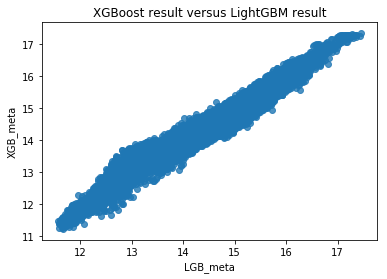

In [11]:
# Observe correlation between XGBoost and LightGBM result
g = sns.regplot(x='LGB_meta',y='XGB_meta',data=test_meta,fit_reg=False)
_ = g.set_title('XGBoost result versus LightGBM result')

Clearly, for a fixed lightGBM prediction, XGBoost prediction has an uncertainty around 1, and vice versa. This may indicate the limit of prediction. This uncertainty can be real fluctuation of a customer's investment.

In [8]:
'''
# An ExtraTrees regressor and a LightGBM regressor are trained using meta features of training data
folds = KFold(n_splits=5, shuffle=True, random_state=1)
oof_preds = np.zeros(train_meta.shape[0])
# sub_preds = np.zeros(test_meta.shape[0])

for n_fold, (trn_, val_) in enumerate(folds.split(train_meta)):

    reg = ExtraTreesRegressor(
        n_estimators=1500, 
        max_features=.8,                       
        max_depth=12, 
        min_samples_leaf=5, 
        random_state=3, 
        n_jobs=-1
    )

    reg = lgb.LGBMRegressor(
        num_leaves=60,
        subsample=.4,
        colsample_bytree=.6,
        max_depth=2,
        learning_rate=0.1,
        objective='regression',
        random_state=3,
        boosting_type='gbdt',
        seed=3,
        min_child_weight=np.power(10,-0.1477),
        reg_lambda=np.power(10,1.7570),
        reg_alpha=np.power(10,-2.2887),
        min_split_gain=np.power(10,-2.5988)
    )
    # Fit Extra Trees
    reg.fit(train_meta.iloc[trn_], np.log1p(data['target'].iloc[trn_]))
    # Get OOF predictions
    oof_preds[val_] = reg.predict(train_meta.iloc[val_])
    # Update TEST predictions
    # sub_preds += reg.predict(test_meta) / folds.n_splits
    # Display fold's score
    print('Fold %d scores : TRN %.4f TST %.4f'
          % (n_fold + 1,
             mean_squared_error(np.log1p(data['target'].iloc[trn_]),
                                reg.predict(train_meta.iloc[trn_])) ** .5,
             mean_squared_error(np.log1p(data['target'].iloc[val_]),
                                reg.predict(train_meta.iloc[val_])) ** .5))
          
print('Full OOF score : %.4f' % (mean_squared_error(np.log1p(data['target']), oof_preds) ** .5))
'''

NameError: name 'train_meta' is not defined

In [15]:
'''
# for cv test
folds = KFold(n_splits=5, shuffle=True, random_state=1)
oof_preds = np.zeros(hist_data.shape[0])
# sub_preds = np.zeros(hist_test.shape[0])

for n_fold, (trn_, val_) in enumerate(folds.split(hist_data)):
    reg = ExtraTreesRegressor(
        n_estimators=1441, 
        max_features=.25,                       
        max_depth=50, 
        min_samples_leaf=6, 
        random_state=3, 
        n_jobs=-1
    )
    # Best parameters after grid search.
    reg = lgb.LGBMRegressor(
        num_leaves=60,
        subsample=.4,
        colsample_bytree=.6,
        max_depth=2,
        learning_rate=0.1,
        objective='regression',
        random_state=3,
        boosting_type='gbdt',
        seed=3,
        min_child_weight=np.power(10,-0.1477),
        reg_lambda=np.power(10,1.7570),
        reg_alpha=np.power(10,-2.2887),
        min_split_gain=np.power(10,-2.5988)
    )
    reg = lgb.LGBMRegressor(
        objective='regression',
        random_state=3,
        learning_rate=0.034396482189098944,
        max_bin=1000,
        max_depth=7,
        min_child_samples=18,
        min_child_weight=5,
        boosting_type='gbdt',
        min_split_gain=0.005475890955639273,
        n_estimators=146,
        num_leaves=23,
        reg_lambda=0.022998236675593222
    ) # Best parameters after Bayes search.
    # Fit Extra Trees
    reg.fit(hist_data[trn_], np.log1p(data['target'].iloc[trn_]))
    # Update TEST predictions
    # sub_preds += reg.predict(hist_test) / folds.n_splits    
    # Get OOF predictions
    oof_preds[val_] = reg.predict(hist_data[val_])
    # Display fold's score
    print('Fold %d scores : TRN %.4f TST %.4f'
          % (n_fold + 1,
             mean_squared_error(np.log1p(data['target'].iloc[trn_]),
                                reg.predict(hist_data[trn_])) ** .5,
             mean_squared_error(np.log1p(data['target'].iloc[val_]),
                                reg.predict(hist_data[val_])) ** .5))
          
print('Full OOF score : %.4f' % (mean_squared_error(np.log1p(data['target']), oof_preds) ** .5))
'''

Fold 1 scores : TRN 1.2342 TST 1.4022
Fold 2 scores : TRN 1.2459 TST 1.3642
Fold 3 scores : TRN 1.2482 TST 1.3485
Fold 4 scores : TRN 1.2361 TST 1.3847
Fold 5 scores : TRN 1.2405 TST 1.3819
Full OOF score : 1.3764


In [38]:
#customerid = data['ID']
#result = pd.Series(gbm.predict(test_x),name='target')
#result = pd.Series(oof_preds,name='target')
#result = pd.concat([customerid,result],axis=1)
#min_value = train_y.min()
#result.loc[result['target'] < min_value,'target'] = min_value
#result.to_csv('Santander_train_2.csv',index=False)


test['target'] = np.expm1(sub_preds)
test[['ID', 'target']].to_csv('xgb+RF_with_leak.csv', index=False)